In [1]:
import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical

pd.options.mode.chained_assignment = None
seed = 101

/Users/yahya/anaconda/envs/deeplearningkeras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yahya/anaconda/envs/deeplearningkeras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Loading and Preprocessing of data

In [2]:
data = pd.read_csv('input/data_challenge.csv',index_col=0)

In [3]:
data = shuffle(data,random_state=seed)
data.head()

,DX,AGE,MONTH,SEX,Absent,Present
9697,c_0036,38.0,2,0,s_0553,"s_0542, s_0290, s_0837, s_0084, s_1266, s_0180"
31843,c_0499,55.0,8,0,NaN,"s_1547, s_0653"
63932,c_0152,35.0,10,0,"s_0070, s_0653, s_0039, s_0078, s_2734, s_0837...","s_1611, s_0445, s_0542, s_0084, s_0315, s_0478..."
69507,c_0145,26.0,6,1,"s_0106, s_0542, s_0124, s_0084, s_0180","s_0136, s_0290, s_2734"
64367,c_0036,61.0,4,0,"s_0070, s_0180, s_0553, s_0039, s_1611, s_0136...","s_0227, s_0078, s_0786, s_0084, s_0356, s_0739"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71662 entries, 9697 to 45919
Data columns (total 6 columns):
DX         71662 non-null object
AGE        71662 non-null float64
MONTH      71662 non-null int64
SEX        71662 non-null int64
Absent     64343 non-null object
Present    66392 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 3.8+ MB


The following bar plot shows how imbalanced the dataset is as we can see number of total patients diagnosed with a specific deseese vary from over tens of thousands for classes like c_0608 amd c_0145 to under 100 for classes like c_0184 and c_0498. This makes multiclass classification job and its evaluation alot more challenging.

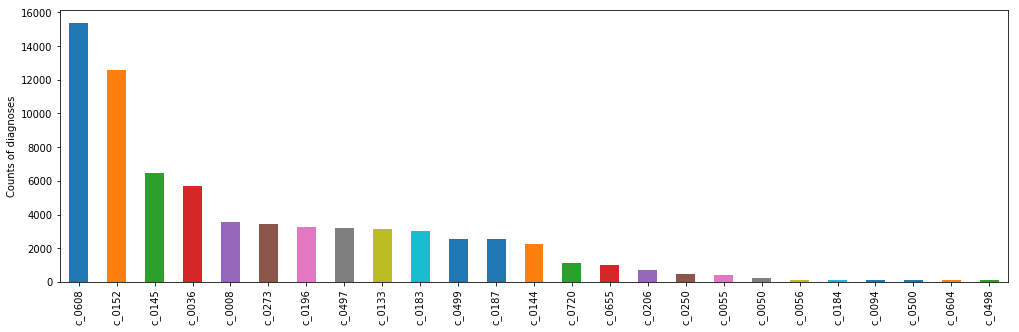

In [5]:
plt.figure(figsize=(17, 5))
plt.ylabel("Counts of diagnoses")
data['DX'].value_counts().plot(kind='bar')

In [6]:
values = data['DX'].value_counts().keys().tolist()
counts = data['DX'].value_counts().tolist()

In [7]:
data.dropna(subset=['Present'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66392 entries, 9697 to 45919
Data columns (total 6 columns):
DX         66392 non-null object
AGE        66392 non-null float64
MONTH      66392 non-null int64
SEX        66392 non-null int64
Absent     60523 non-null object
Present    66392 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 3.5+ MB


# Preparation of Train and Test Data

In [8]:
Y = data['DX']
X = data.drop('DX',axis=1)

10 percent of data is randomly sample to be used as test data for evaluation.

In [54]:
test_size = 0.1
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size=test_size, random_state = seed)

In [55]:
class_names = np.unique(y_train)
encoder = LabelEncoder()
encoder.fit(Y)
y_train = encoder.transform(y_train)

Sample weights will be used later to deal with imbalanceness of data.

In [56]:
# class_weight_list = compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weights = dict(zip(np.unique(y_train), class_weight_list))
# class_weight_original_names = dict(zip(class_names, class_weight_list))
# print(f"Class weight: {class_weight_original_names}")

# class_weight_list = 1 / np.bincount(y_train)
# class_weights = dict(zip(np.unique(y_train), class_weight_list))
# class_weight_original_names = dict(zip(class_names, class_weight_list))
# print(f"Class weight: {class_weight_original_names}")

from sklearn.utils import class_weight
sample_weights = class_weight.compute_sample_weight('balanced', y_train)
sample_weights

array([0.18, 0.84, 0.99, ..., 0.18, 1.43, 2.81])

In [57]:
y_train = to_categorical(y_train)

In [58]:
y_test = encoder.transform(y_test)
y_test = to_categorical(y_test)

# Feature Engineering

AGE as a numeric feature needs to be normalized and for that I use standard normalization. For test data 'AGE' is normalized using mean and std that are extracted from training data assuming model has no information about test data.

In [59]:
std = np.std(x_train['AGE'])
mean = np.mean(x_train['AGE'])
x_train['AGE'] -= mean
x_train['AGE'] /= std

In [60]:
x_test['AGE'] -= mean
x_test['AGE'] /= std

Month is an oridnal feature, but is also cyclic, so the best way of representing it is converting it to a circular variable using two features of MONTH_X and MONTH_Y.

In [61]:
month_circum = 12
x_train = pd.concat([x_train, x_train['MONTH'].apply(lambda var:pd.Series({'MONTH_x':np.sin(2 * np.pi * var / month_circum),'MONTH_y':np.cos(2 * np.pi * var / month_circum)}))], axis=1)
x_train.drop('MONTH',axis=1,inplace=True)

In [62]:
x_test = pd.concat([x_test, x_test['MONTH'].apply(lambda var:pd.Series({'MONTH_x':np.sin(2 * np.pi * var / month_circum),'MONTH_y':np.cos(2 * np.pi * var / month_circum)}))], axis=1)
x_test.drop('MONTH',axis=1,inplace=True)

Two features of 'Present' and 'Absent' are lists of symptoms that need to be one-hot encoded together, and that is because symproms that are present for a patient are not absent for him/her but also there are symptoms that are neither present nor absent. For that reason, I first extracted all existing sysmptoms in training data that have been present or absent for different patients. Then of all these extracted symptoms, the ones that are present for each patient are encoded to 1, ones that are absent are encoded to -1 and the remaining ones that are ones that are not aksed for remain zero.

In [63]:
present_symptoms = np.array(x_train['Present'])
absent_symptoms = np.array(x_train['Absent'].dropna())
present_absent_symptoms = np.concatenate((present_symptoms,absent_symptoms),axis=0)

In [64]:
present_absent_symptoms

array(['s_0022, s_2194, s_0084', 's_1611, s_2171, s_0445, s_0180',
       's_1547', ..., 's_0106, s_0542', 's_2738, s_0605', 's_0553'],
      dtype=object)

In [65]:
token_index = {}
symptoms = []
for i,seq in enumerate(present_absent_symptoms):
    for word in seq.split(','):
        word = word.strip()
        if word not in symptoms:
            symptoms.append(word)
            token_index[word] = len(token_index) + 1

In [66]:
print(f"There exists {len(symptoms)} number of symptoms in training data")

There exists 737 number of symptoms in training data


In [67]:
present_samples = np.array(x_train['Present'])
absent_samples = np.array(x_train['Absent'])

In [68]:
present_samples

array(['s_0022, s_2194, s_0084', 's_1611, s_2171, s_0445, s_0180',
       's_1547', ..., 's_0445, s_0864, s_0084', 's_0824',
       's_0270, s_0954, s_1759'], dtype=object)

In [69]:
def one_hot(present_samples,absent_samples):
    results = np.zeros(shape=(len(present_samples),max(token_index.values()) + 1))
    for i, sample in enumerate(absent_samples):
        if sample == '' or pd.isnull(sample):
            pass
        else:
            for j, word in list(enumerate(sample.split(','))):
                word = word.strip()
                index = token_index.get(word,None)
                if index:
                    results[i, index] = -1
    for i, sample in enumerate(present_samples):
        for j, word in list(enumerate(sample.split(','))):
            word = word.strip()
            index = token_index.get(word,None)
            if index:
                results[i, index] = 1
    return results

In [70]:
encoded_symptoms =  one_hot(present_samples,absent_samples)

In [71]:
x_train.drop(columns=['Present','Absent'],axis=1,inplace=True)

In [72]:
x_train = np.array(x_train)

In [73]:
x_train = np.concatenate((x_train,encoded_symptoms),axis=1)

In [74]:
x_train.shape

(59752, 742)

In [75]:
output_dim = y_train.shape[1]
output_dim

25

In [76]:
input_dim = x_train.shape[1]
input_dim

742

The same symptoms that are extracted from training data with its corresponding token index will be used to one hot encode the test data. The sysmptoms that happen to exist in test data that did not appear in any of patients in training data will be treated as not asked and encoded to zero.

In [78]:
test_present_samples = np.array(x_test['Present'])
test_absent_samples = np.array(x_test['Absent'])
test_results =  one_hot(test_present_samples,test_absent_samples)
x_test.drop(columns=['Present','Absent'],axis=1,inplace=True)
x_test = np.array(x_test)
x_test = np.concatenate((x_test,test_results),axis=1)

# Training dense neural network without handling imbalanced dataset

The first 10000 samples of training data will be used for validation, and the remaining is the data that dense neural network model will use for training.

In [77]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

I use dense NN with 4 hidden layers each also consisting a dropout layer with fraction rate of 0.3 (came up with though experimentation) to fight overfitting. The input_dim is the number of dimensions in a each input sample (here 742) with the last layer having output_dim number of output nodes with activation function of softmax that gives probababilities per each output node.

In [34]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(output_dim, activation='softmax'))

Model is compiled using optimizer of RMSprop with learningrate of 0.001 and loss function of 'categorical_crossentropy' (because it is a multiclass classification problem), and trained for 50 epochs.

In [35]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Train on 49752 samples, validate on 10000 samples
Epoch 1/50
49752/49752 [==============================] - 2s 33us/step - loss: 2.0853 - acc: 0.3626 - val_loss: 1.5970 - val_acc: 0.4936
Epoch 2/50
49752/49752 [==============================] - 1s 25us/step - loss: 1.6378 - acc: 0.4843 - val_loss: 1.4445 - val_acc: 0.5339
Epoch 3/50
49752/49752 [==============================] - 1s 27us/step - loss: 1.5181 - acc: 0.5187 - val_loss: 1.3709 - val_acc: 0.5552
Epoch 4/50
49752/49752 [==============================] - 1s 28us/step - loss: 1.4381 - acc: 0.5399 - val_loss: 1.3155 - val_acc: 0.5756
Epoch 5/50
49752/49752 [==============================] - 2s 40us/step - loss: 1.3826 - acc: 0.5595 - val_loss: 1.2885 - val_acc: 0.5873
Epoch 6/50
49752/49752 [==============================] - 2s 31us/step - loss: 1.3458 - acc: 0.5712 - val_loss: 1.2683 - val_acc: 0.5898
Epoch 7/50
49752/49752 [==============================] - 2s 35us/step - loss: 1.3206 - acc: 0.5789 - val_loss: 1.2484 - val_acc

The diagram of training and validation loss per epoch shows that using the right ratio in dropout layers has been able to prevent validation and training getting so far apart, with validation loss stabilizing around loss of 1.23 at 50th epoch. We also do not have underfitting issue as training loss has been constantly reducing and getting stabilized which indicates the right number of parameters and layers are used for NN model. Training and validation accuracy per epoch also shows that validation acuracy reaches around 61% as by using number of epochs higher than 15, model starts overfitting with training loss further reducing while validation loss and accuracy staying almost constant.

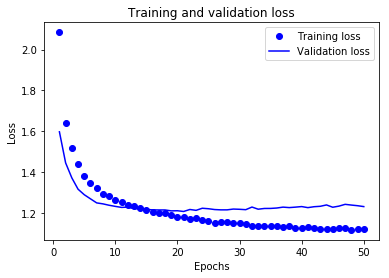

In [36]:
history_dict = history.history
acc = history.history['acc']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

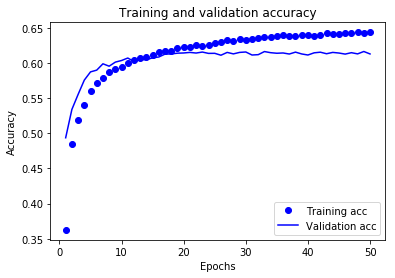

In [37]:
plt.clf()
acc_values = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation of the trained Neural Network model

Trained model is being evaluated on test set that results in loss of 1.23 and accuracy of around 61%. Since the dataset is highly imbalanced, it is preferred to evaluate model using other criteria like confusion matrix or f1score.

In [38]:
evaluation_results = model.evaluate(x_test, y_test)

6640/6640 [==============================] - 0s 21us/step


In [39]:
evaluation_results

[1.2330117329057442, 0.6090361445783132]

In [40]:
predictions = model.predict_classes(x_test)

In [41]:
predictions

array([ 1, 22,  1, ...,  8,  9, 16])

Confusion matrix shows how the model has performed across different classes. In the following heatmap of normalized confusion matrix, diagonal pixels show accuracy for different classes where brighter colors indicate higher accuracy and darker colors show lower accuracy. As you can see these accuracies are all around the place from being high for classes like c_0133 that has thousands of samples to almost zero for 5 classes like c_0500 that have few samples. It means that model has done poorly across classes with fewer number of data points even though the overall f1score is 61.5%. However, if we are looking for a model that overall performs well for classes that have good number of points, this model can be a good selection since it also results in over 67% of weighted accuracy.

In [42]:
y_test_original = np.argmax(y_test, axis=1)
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test_original, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, range(25),range(25))
le_name_mapping = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
df_cm.index = df_cm.index.map(le_name_mapping)
df_cm.columns = df_cm.columns.map(le_name_mapping)

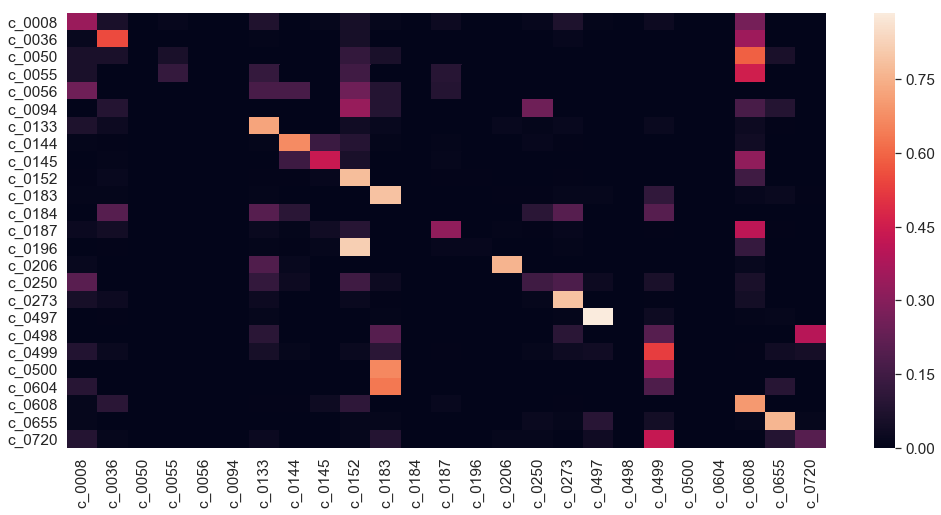

In [43]:
plt.figure(figsize=(17, 8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=False,annot_kws={"size": 16})# font size

In [44]:
pd.Series(np.diag(df_cm), index=[df_cm.index])

c_0008    0.340984
c_0036    0.550699
c_0050    0.000000
c_0055    0.121212
c_0056    0.000000
c_0094    0.000000
c_0133    0.726073
c_0144    0.673171
c_0145    0.437500
c_0152    0.781329
c_0183    0.790076
c_0184    0.000000
c_0187    0.320463
c_0196    0.013841
c_0206    0.759259
c_0250    0.147059
c_0273    0.789137
c_0497    0.885621
c_0498    0.000000
c_0499    0.527473
c_0500    0.000000
c_0604    0.000000
c_0608    0.701503
c_0655    0.761905
c_0720    0.197531
dtype: float64

In [45]:
from sklearn.metrics import f1_score
print("Micro average f1 score: {:.3f}".format (f1_score(y_test_original, predictions, average="micro")))

Micro average f1 score: 0.609


In [46]:
from sklearn.metrics import accuracy_score
w = np.ones(y_test_original.shape[0])
for idx, i in enumerate(np.bincount(y_test_original)):
    w[y_test_original == idx] *= (i/float(y_test_original.shape[0]))
accuracy_score(y_test_original, predictions, sample_weight=w)

0.6746538392737715

# Training dense neural network with handling imbalanced dataset

Keras introduces a parameter called sample_weight in model fitting that allows further control of the relative weight of samples that belong to the same class that affects the relative weight of samples belonging to each class in the calculation of their objective function. The result is that in cost function it is penalizing wrong classification of the rare class more than wrong classifications of the abundant class.
In this case to avoid underfitting I needed to more numbe rof parameters with a lower rate for dropout layers.

In [80]:
sample_weights = sample_weights[10000:]

In [145]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(input_dim,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(output_dim, activation='softmax'))

In [146]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=128,
                    sample_weight=sample_weights,
                    validation_data=(x_val, y_val))

Train on 49752 samples, validate on 10000 samples
Epoch 1/50
49752/49752 [==============================] - 3s 68us/step - loss: 2.6335 - acc: 0.2869 - val_loss: 1.9603 - val_acc: 0.3991
Epoch 2/50
49752/49752 [==============================] - 2s 45us/step - loss: 1.9999 - acc: 0.3691 - val_loss: 1.8223 - val_acc: 0.4185
Epoch 3/50
49752/49752 [==============================] - 2s 43us/step - loss: 1.7751 - acc: 0.3902 - val_loss: 1.7801 - val_acc: 0.3873
Epoch 4/50
49752/49752 [==============================] - 2s 44us/step - loss: 1.6266 - acc: 0.4027 - val_loss: 1.6758 - val_acc: 0.4127
Epoch 5/50
49752/49752 [==============================] - 2s 46us/step - loss: 1.5027 - acc: 0.4156 - val_loss: 1.6404 - val_acc: 0.3956
Epoch 6/50
49752/49752 [==============================] - 2s 43us/step - loss: 1.4097 - acc: 0.4215 - val_loss: 1.6166 - val_acc: 0.4250
Epoch 7/50
49752/49752 [==============================] - 2s 43us/step - loss: 1.3207 - acc: 0.4337 - val_loss: 1.5579 - val_acc

Validation and training loss diagram show that after epoch of 8 model starts overfitting with training loss continuing to reduce while validation loss getting stabilized. The same is true for validation and training accuracies that after epoch 8 as training accuracy increases, validation accuracy fluctuates up untill it reaches accuracy of around 48% although two accuracies do not open so much distance due to appropriate use of dropout layers.

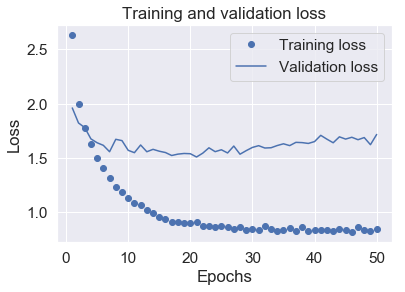

In [147]:
history_dict = history.history
acc = history.history['acc']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

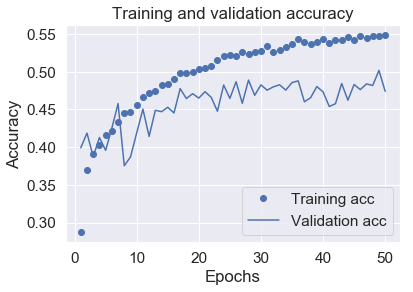

In [148]:
plt.clf()
acc_values = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Evaluation results for model with sample_weight as parameter om test data results in accuracy of around 47%.

In [149]:
evaluation_results = model.evaluate(x_test, y_test)
evaluation_results

6640/6640 [==============================] - 0s 38us/step


[1.698161794765886, 0.4667168674698795]

In [150]:
predictions = model.predict_classes(x_test)
predictions

array([ 1,  1,  1, ...,  8,  9, 16])

If we look at heatmap of normalized confusion matrix we can see that for diagonal pixels that represent per class accuracy, now the number of dark pixels has reduced. In previous case there existed 5 classes with accuracy of zero, but now no class has accuracy of zero and accuracies are more evenly distributed across different classes. However, XGBoost model shows a better result in handling imbalanced data compared to NN model. Therefore, the best model I suggest for prediction in this problem that can also handle imbalanceness in classes is XGBoost.

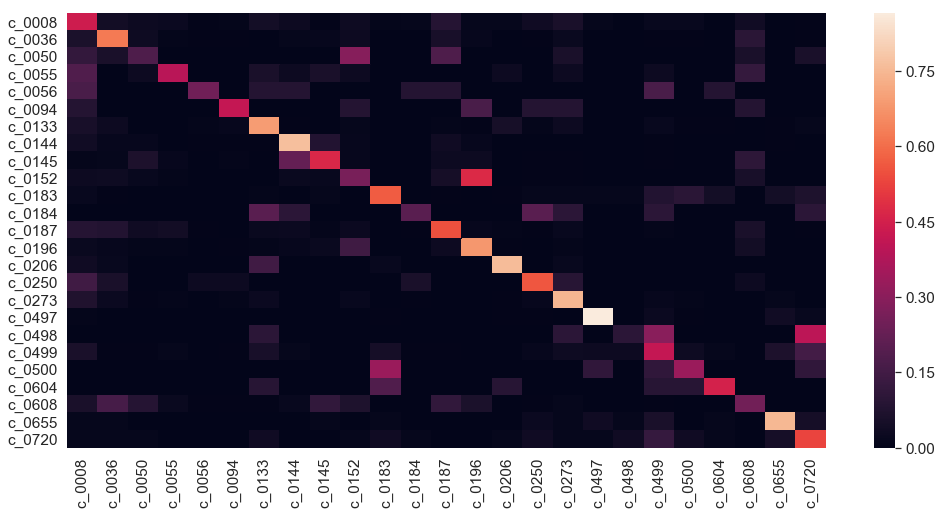

In [151]:
y_test_original = np.argmax(y_test, axis=1)
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test_original, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, range(25),range(25))
le_name_mapping = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
df_cm.index = df_cm.index.map(le_name_mapping)
df_cm.columns = df_cm.columns.map(le_name_mapping)
plt.figure(figsize=(17, 8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=False,annot_kws={"size": 16})# font size

In [152]:
pd.Series(np.diag(df_cm), index=[df_cm.index])

c_0008    0.439344
c_0036    0.624126
c_0050    0.176471
c_0055    0.393939
c_0056    0.250000
c_0094    0.416667
c_0133    0.693069
c_0144    0.765854
c_0145    0.467949
c_0152    0.265770
c_0183    0.568702
c_0184    0.200000
c_0187    0.548263
c_0196    0.681661
c_0206    0.759259
c_0250    0.558824
c_0273    0.747604
c_0497    0.866013
c_0498    0.100000
c_0499    0.417582
c_0500    0.333333
c_0604    0.454545
c_0608    0.252049
c_0655    0.750000
c_0720    0.530864
dtype: float64